<a href="https://colab.research.google.com/github/dazzerz/Regresi-Logistik-Wine/blob/main/ADK_REGLOG_WINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import warnings
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [2]:
file_ = 'data/winequalityN.csv'
try: # Running Locally, yakinkan "file_" berada di folder "data"

    df = pd.read_csv(file_)
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/dazzerz/Regresi-Logistik-Wine-Dataset/main/winequalityN.csv

    df = pd.read_csv(file_, low_memory=False, encoding = 'utf8')

N, P = df.shape # Ukuran Data
print('baris = ', N, ', Kolom (jumlah variabel) = ', P)
df

baris =  6497 , Kolom (jumlah variabel) =  13


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


##EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


<Axes: >

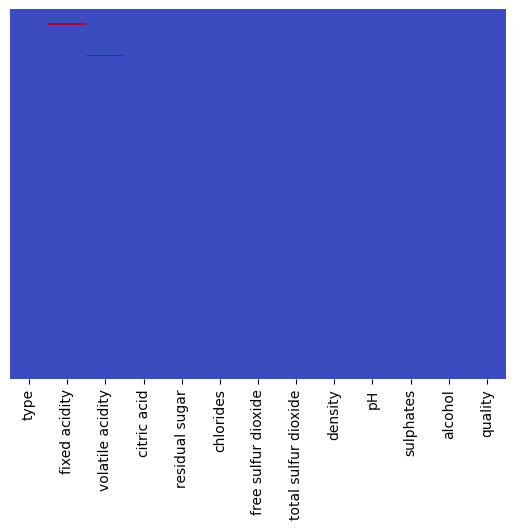

In [4]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [5]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
type,0,0.000000
fixed acidity,10,0.001539
volatile acidity,8,0.001231
citric acid,3,0.000462
residual sugar,2,0.000308
chlorides,2,0.000308
free sulfur dioxide,0,0.000000
total sulfur dioxide,0,0.000000
density,0,0.000000
pH,9,0.001385


In [6]:
def null_cell(df):
    total_missing_values = df.isnull().sum()
    missing_values_per = df.isnull().sum()/df.isnull().count()
    null_values = pd.concat([total_missing_values, missing_values_per], axis=1, keys=['total_null', 'total_null_perc'])
    null_values = null_values.sort_values('total_null', ascending=False)
    return null_values[null_values['total_null'] > 0]

In [7]:
fill_list = (null_cell(df)).index

In [8]:
df_mean = df.copy()

for col in fill_list:
    df_mean.loc[:, col].fillna(df_mean.loc[:, col].mean(), inplace=True)

In [9]:
df_bins= df_mean.copy()

# Data Wrangling

In [10]:
bins = [0,5,10]


labels = [0, 1] # 'low'=0, 'high'=1
df_bins['quality_range']= pd.cut(x=df_bins['quality'], bins=bins, labels=labels)

print(df_bins[['quality_range','quality']].head(5))

df_bins = df_bins.drop('quality', axis=1)

  quality_range  quality
0             1        6
1             1        6
2             1        6
3             1        6
4             1        6


In [11]:
def winsor(x, multiplier=3):
    upper= x.median() + x.std()*multiplier
    for limit in np.arange(0.001, 0.20, 0.001):
        if np.max(winsorize(x,(0,limit))) < upper:
            return limit
    return None

In [12]:
kolom = ['fixed_acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
                                  'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for i in range(1,len(kolom)):

    df_bins[kolom[i]] = winsorize(df_bins[kolom[i]], (0, winsor(df_bins[kolom[i]])))

In [13]:
df_bins.type = df_bins.type.map({'white':0, 'red':1})

In [14]:
df_bins

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range
0,0,7.0,0.270,0.36,17.2,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,1
1,0,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,1
2,0,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,1
3,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
4,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,0
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,1
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,1
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,0


#Split Data

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_bins_VIF = df_bins

# Extract the features used in the logistic regression model
features_for_vif = df_bins_VIF

# Add a constant term to the features for VIF calculation
features_for_vif = sm.add_constant(features_for_vif)


# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = features_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(features_for_vif.values, i) for i in range(features_for_vif.shape[1])]

vif_data['VIF_decimal'] = vif_data['VIF'] / 1e1

vif_data

,Variable,VIF,VIF_decimal
0,const,2.899843e+06,289984.329900
1,type,7.918488e+00,0.791849
2,fixed acidity,5.450356e+00,0.545036
3,volatile acidity,2.375771e+00,0.237577
4,citric acid,1.638710e+00,0.163871
5,residual sugar,1.040817e+01,1.040817
6,chlorides,2.156342e+00,0.215634
7,free sulfur dioxide,2.340292e+00,0.234029
8,total sulfur dioxide,4.166830e+00,0.416683
9,density,2.587587e+01,2.587587


1.   Variabel "density" memiliki nilai VIF yang sangat tinggi (25.87587), menunjukkan adanya multikolinearitas yang signifikan dengan variabel lain.
2.   "Residual sugar" juga memiliki nilai VIF yang relatif tinggi (10.40817).

Variabel lain memiliki nilai VIF di bawah ambang batas yang umumnya digunakan untuk mempertimbangkan masalah multikolinearitas. Maka kami memutuskan untuk menghilangkan variabel tearsebut

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
X = df_bins[['type', 'alcohol', 'volatile acidity', 'chlorides',
       'citric acid', 'fixed acidity', 'free sulfur dioxide',
       'total sulfur dioxide', 'sulphates', 'pH']]
y = df_bins.quality_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

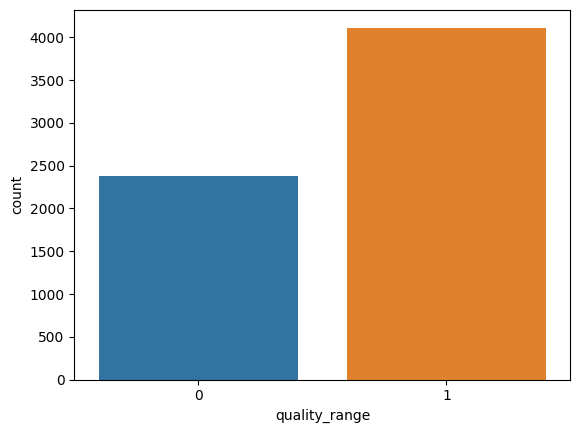

1    4113
0    2384
Name: quality_range, dtype: int64
Presentase 0 = 36.69385870401724 Presentase 1 = 63.30614129598276


In [18]:
# Visual Python: Visualization > Seaborn
from collections import Counter

sns.countplot(data=df_bins, x='quality_range')
plt.show()

# Menghitung frekuensi masing-masing nilai
value_counts = df_bins['quality_range'].value_counts()
print(value_counts)

# Menghitung presentase masing-masing nilai
percentage_0 = (value_counts[0] / len(df_bins['quality_range'])) * 100
percentage_1 = (value_counts[1] / len(df_bins['quality_range'])) * 100

print("Presentase 0 =", percentage_0, "Presentase 1 =", percentage_1)

#Fit Model RegLog Sklearn

# VIF Data

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
model = LogisticRegression(max_iter=1000)  # Sesuaikan nilai max_iter sesuai kebutuhan

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Penskalaan fitur-fitur pada data latih
X_train_scaled = scaler.fit_transform(X_train)

# Penskalaan fitur-fitur pada data uji menggunakan parameter yang sama dari data latih
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

# R-squared model

In [20]:
r_squared = model.score(X_train_scaled, y_train)

print(f"R-squared: {r_squared}")

R-squared: 0.7335000962093515


# Fit Model Reglog SM

In [21]:
# Tambahkan nilai konstan ke fitur untuk model regresi logistik
X_train_wald = sm.add_constant(X_train_scaled)
X_test_wald = sm.add_constant(X_test_scaled)
# Pasang model regresi logistik
model_logit = sm.Logit(y_train, X_train_wald)
hasil = model_logit.fit()

# Lakukan uji Wald untuk signifikansi keseluruhan
uji_wald = hasil.wald_test(np.eye(len(hasil.params)), scalar=False)
# Note: np.eye(len(hasil.params)) menghasilkan matriks identitas seukuran jumlah parameter model

p_value_simultaneous = uji_wald.pvalue

print(f"F-Statistic Tes Simultan: {uji_wald.statistic[0][0]}")
print(f"P-Value Tes Simultan: {p_value_simultaneous}")
print(f"Nilai AIC: {hasil.aic}")

Optimization terminated successfully.
         Current function value: 0.518459
         Iterations 6
F-Statistic Tes Simultan: 1125.2085552925278
P-Value Tes Simultan: 2.11156773878641e-234
Nilai AIC: 5410.861246709263


#Signifikansi Variable Menggunakan P-Value

# Seleksi Fitur dan Fit Model Reglog SM Seleksi Fitur
Train model reglog sklearn setelah dilakukannya seleksi fitur
menghilangkan variabel yang tidak signifikan p-value > a

In [22]:
coeficients = hasil.params
p_values = hasil.pvalues

for i, (coef, p_value) in enumerate(zip(coeficients[0:], p_values[0:]), start=0):
    print(f"Variabel {i}: Coef = {coef}, P-Value = {p_value}")

Variabel 0: Coef = 0.7485487771387123, P-Value = 4.0070982936340046e-98
Variabel 1: Coef = 0.15524958396024927, P-Value = 0.05593479931145635
Variabel 2: Coef = 1.0272188369584672, P-Value = 1.2673173351088503e-109
Variabel 3: Coef = -0.7731724828399172, P-Value = 3.145965395884443e-49
Variabel 4: Coef = -0.06935665342778481, P-Value = 0.1272402234730068
Variabel 5: Coef = -0.06911711386350482, P-Value = 0.08668129799169547
Variabel 6: Coef = -0.06696391524477986, P-Value = 0.15786979732446949
Variabel 7: Coef = 0.4145599623756048, P-Value = 2.611567328428825e-16
Variabel 8: Coef = -0.3144002257216797, P-Value = 1.494556961051083e-06
Variabel 9: Coef = 0.3096717946923532, P-Value = 7.112049561909266e-13
Variabel 10: Coef = -0.011685698542111758, P-Value = 0.7798327592494537


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Menghilangkan satu-satu variable
X_AIC1 = df_bins[['type', 'alcohol', 'volatile acidity', 'chlorides',
       'citric acid', 'fixed acidity', 'free sulfur dioxide',
       'total sulfur dioxide', 'sulphates']]
y_AIC1 = df_bins.quality_range

X_train_AIC1, X_test_AIC1, y_train_AIC1, y_test_AIC1 = train_test_split(X_AIC1,y_AIC1, test_size=0.2, random_state=40)

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Penskalaan fitur-fitur pada data latih
X_train_AIC1_scaled = scaler.fit_transform(X_train_AIC1)

# Penskalaan fitur-fitur pada data uji menggunakan parameter yang sama dari data latih
X_test_AIC1_scaled = scaler.transform(X_test_AIC1)
X_test_AIC1_scaled_cons = sm.add_constant(X_test_AIC1_scaled)


X_train_AIC1_scaled_cons = sm.add_constant(X_train_AIC1_scaled)
model_logit_AIC1 = sm.Logit(y_train_AIC1, X_train_AIC1_scaled_cons)
hasil_AIC1 = model_logit_AIC1.fit()
print(hasil_AIC1.aic)

Optimization terminated successfully.
         Current function value: 0.518466
         Iterations 6
5408.939359272808


In [24]:
# Menghilangkan satu-satu variable\
X_AIC2 = df_bins[['type', 'alcohol', 'volatile acidity', 'chlorides',
       'citric acid', 'fixed acidity', 'free sulfur dioxide',
       'total sulfur dioxide']]
y_AIC2 = df_bins.quality_range

X_train_AIC2, X_test_AIC2, y_train_AIC2, y_test_AIC2 = train_test_split(X_AIC2,y_AIC2, test_size=0.2, random_state=40)

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Penskalaan fitur-fitur pada data latih
X_train_AIC2_scaled = scaler.fit_transform(X_train_AIC2)

# Penskalaan fitur-fitur pada data uji menggunakan parameter yang sama dari data latih
X_test_AIC2_scaled = scaler.transform(X_test_AIC2)

X_train_AIC2_scaled_cons = sm.add_constant(X_train_AIC2_scaled)
X_test_AIC2_scaled_cons = sm.add_constant(X_test_AIC2_scaled)


model_logit_AIC2 = sm.Logit(y_train_AIC2, X_train_AIC2_scaled_cons)
hasil_AIC2 = model_logit_AIC2.fit()
print(hasil_AIC2.aic)

Optimization terminated successfully.
         Current function value: 0.523641
         Iterations 6
5460.724341167661


In [25]:
# Menghilangkan variable berdasarkan nilai p-value > a


X_AIC3 = df_bins[['alcohol', 'volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']]
y_AIC3 = df_bins.quality_range

X_train_AIC3, X_test_AIC3, y_train_AIC3, y_test_AIC3 = train_test_split(X_AIC3,y_AIC3, test_size=0.2, random_state=40)

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Penskalaan fitur-fitur pada data latih
X_train_AIC3_scaled = scaler.fit_transform(X_train_AIC3)

# Penskalaan fitur-fitur pada data uji menggunakan parameter yang sama dari data latih
X_test_AIC3_scaled = scaler.transform(X_test_AIC3)

X_train_AIC3_scaled_cons = sm.add_constant(X_train_AIC3_scaled)
X_test_AIC3_scaled_cons = sm.add_constant(X_test_AIC3_scaled)

model_logit_AIC3 = sm.Logit(y_train_AIC3, X_train_AIC3_scaled_cons)
hasil_AIC3 = model_logit_AIC3.fit()
print(hasil_AIC3.aic)

Optimization terminated successfully.
         Current function value: 0.519753
         Iterations 6
5414.308290930925


In [67]:
print(f"Nilai AIC Seluruh Variable          : {hasil.aic}")
print(f"Nilai AIC -1 Variable               : {hasil_AIC1.aic}")
print(f"Nilai AIC -2 Variable               : {hasil_AIC2.aic}")
print(f"Nilai AIC Variable yang Signifikan  : {hasil_AIC3.aic}")

Nilai AIC Seluruh Variable          : 5410.861246709263
Nilai AIC -1 Variable               : 5408.939359272808
Nilai AIC -2 Variable               : 5460.724341167661
Nilai AIC Variable yang Signifikan  : 5414.308290930925


# Perbandingan Akurasi Model Sklearn dan SM serta SM dengan Seleksi Fitur

In [27]:
# Model 1
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

# Model 2
y_pred_train2 = hasil_AIC3.predict(X_train_AIC3_scaled_cons)
y_pred_train_class2 = (y_pred_train2 > 0.5).astype(int)
accuracy_train2 = np.mean(y_pred_train_class2 == y_train_AIC3)
y_pred_test2 = hasil_AIC3.predict(X_test_AIC3_scaled_cons)
y_pred_test_class2 = (y_pred_test2 > 0.5).astype(int)
accuracy_test2 = np.mean(y_pred_test_class2 == y_test_AIC3)

# Model 3
y_pred_train = hasil.predict(X_train_wald)
y_pred_train_class = (y_pred_train > 0.5).astype(int)
accuracy_train = np.mean(y_pred_train_class == y_train)
y_pred_test = hasil.predict(X_test_wald)
y_pred_test_class = (y_pred_test > 0.5).astype(int)
accuracy_test = np.mean(y_pred_test_class == y_test)

# Model 4
y_pred_train3 = hasil_AIC1.predict(X_train_AIC1_scaled_cons)
y_pred_train_class3 = (y_pred_train3 > 0.5).astype(int)
accuracy_train3 = np.mean(y_pred_train_class3 == y_train_AIC1)
y_pred_test3 = hasil_AIC1.predict(X_test_AIC1_scaled_cons)
y_pred_test_class3 = (y_pred_test3 > 0.5).astype(int)
accuracy_test3 = np.mean(y_pred_test_class3 == y_test_AIC1)

# Model 5
y_pred_train4 = hasil_AIC2.predict(X_train_AIC2_scaled_cons)
y_pred_train_class4 = (y_pred_train4 > 0.5).astype(int)
accuracy_train4 = np.mean(y_pred_train_class4 == y_train_AIC2)
y_pred_test4 = hasil_AIC2.predict(X_test_AIC2_scaled_cons)
y_pred_test_class4 = (y_pred_test4 > 0.5).astype(int)
accuracy_test4 = np.mean(y_pred_test_class4 == y_test_AIC2)

print('Akurasi Model Reglog Sklearn Data Train                  : {:.4f}'.format(train_accuracy),
      'Akurasi Model Reglog Sklearn Data Test                   : {:.4f}'.format(test_accuracy), sep='\n')
print('--'*30)
print('Akurasi Model Reglog SM Data Train (Seleksi Fitur Var.Sig)       : {:.4f}'.format(accuracy_train2),
      'Akurasi Model Reglog SM Data Test (Seleksi Fitur Var.Sig)        : {:.4f}'.format(accuracy_test2), sep='\n')
print('--'*30)
print(f"Akurasi Model Reglog SM Data Train                      : {accuracy_train:.4f}")
print(f"Akurasi Model Reglog SM Data Test                       : {accuracy_test:.4f}")
print('--'*30)
print('Akurasi Model Reglog SM Data Train (Seleksi Fitur -1 var)       : {:.4f}'.format(accuracy_train3),
      'Akurasi Model Reglog SM Data Test (Seleksi Fitur -1 var)        : {:.4f}'.format(accuracy_test3), sep='\n')
print('--'*30)
print('Akurasi Model Reglog SM Data Train (Seleksi Fitur -2 var)       : {:.4f}'.format(accuracy_train4),
      'Akurasi Model Reglog SM Data Test (Seleksi Fitur -2 var)        : {:.4f}'.format(accuracy_test4), sep='\n')
print('--'*30)

Akurasi Model Reglog Sklearn Data Train                  : 0.7335
Akurasi Model Reglog Sklearn Data Test                   : 0.7246
------------------------------------------------------------
Akurasi Model Reglog SM Data Train (Seleksi Fitur Var.Sig)       : 0.7320
Akurasi Model Reglog SM Data Test (Seleksi Fitur Var.Sig)        : 0.7277
------------------------------------------------------------
Akurasi Model Reglog SM Data Train                      : 0.7331
Akurasi Model Reglog SM Data Test                       : 0.7246
------------------------------------------------------------
Akurasi Model Reglog SM Data Train (Seleksi Fitur -1 var)       : 0.7339
Akurasi Model Reglog SM Data Test (Seleksi Fitur -1 var)        : 0.7254
------------------------------------------------------------
Akurasi Model Reglog SM Data Train (Seleksi Fitur -2 var)       : 0.7333
Akurasi Model Reglog SM Data Test (Seleksi Fitur -2 var)        : 0.7215
------------------------------------------------------

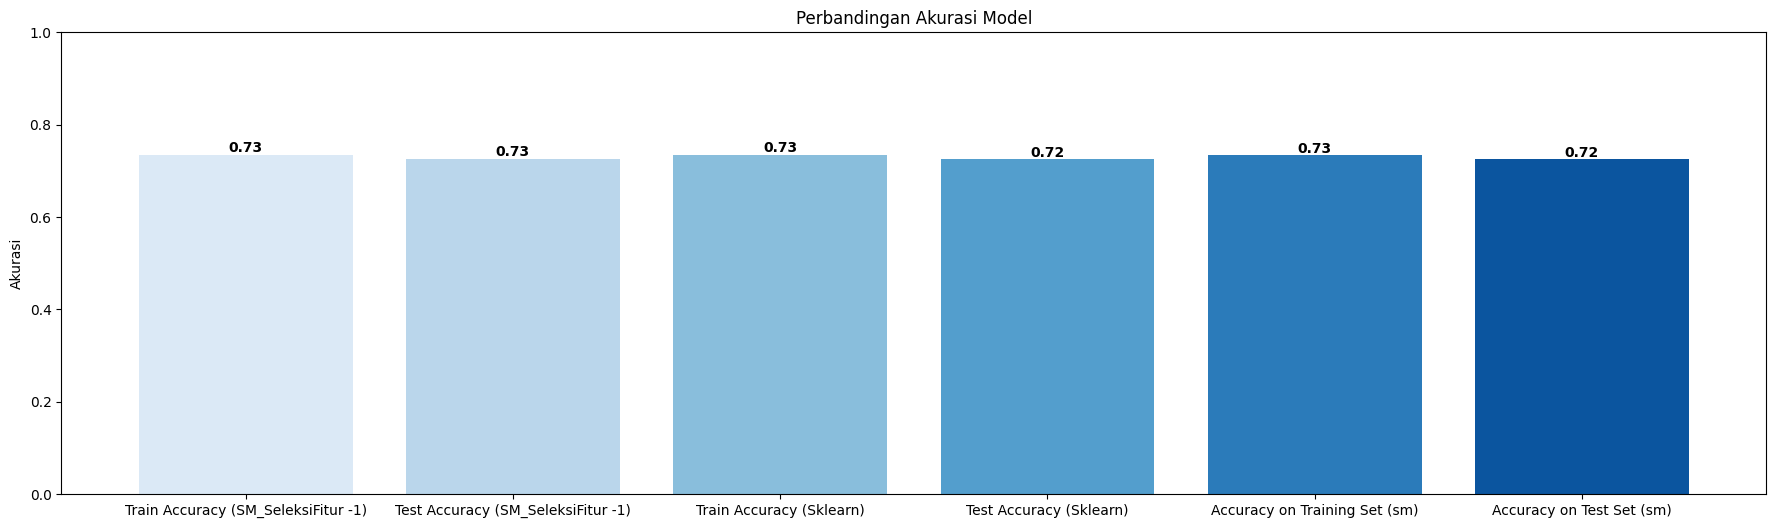

In [28]:
import matplotlib.pyplot as plt
# Warna
blue_palette = sns.color_palette("Blues", 6)

# Akurasi
accuracies = [accuracy_train3, accuracy_test3, train_accuracy, test_accuracy, accuracy_train, accuracy_test]
labels = ['Train Accuracy (SM_SeleksiFitur -1)', 'Test Accuracy (SM_SeleksiFitur -1)', 'Train Accuracy (Sklearn)', 'Test Accuracy (Sklearn)', 'Accuracy on Training Set (sm)', 'Accuracy on Test Set (sm)']

# Plot
fig, ax = plt.subplots(figsize=(22, 6))
bars = ax.bar(labels, accuracies, color=blue_palette)

# Menambahkan judul dan label
ax.set_ylabel('Akurasi')
ax.set_title('Perbandingan Akurasi Model')
ax.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Menambahkan nilai akurasi diatas bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

# Perbandingan CM Sklearn dan SM

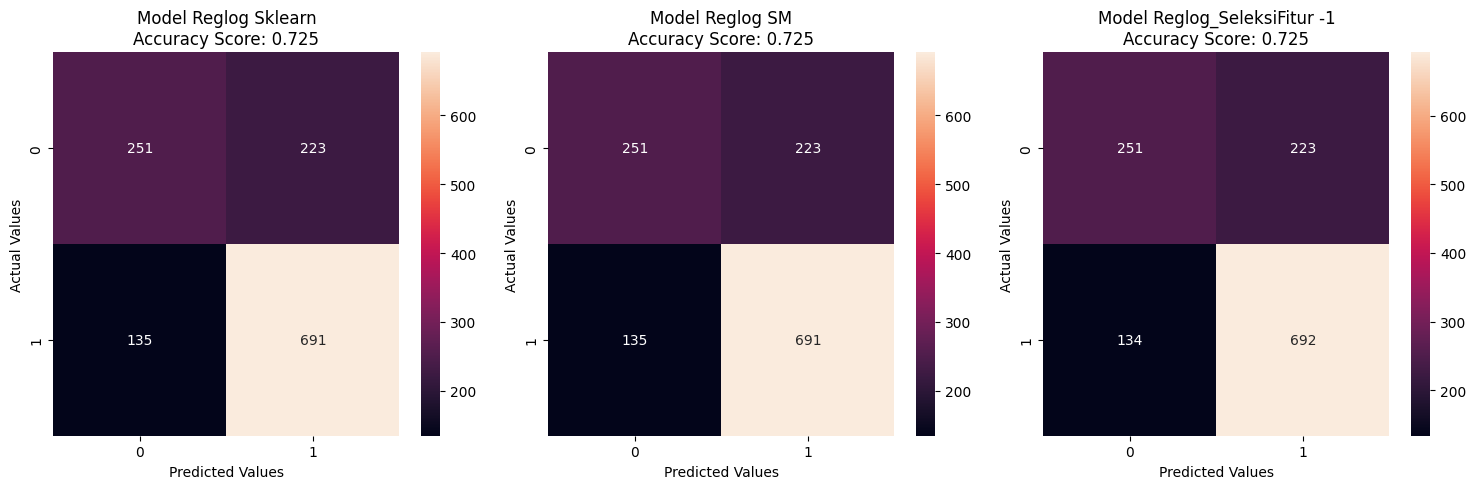

In [30]:
# 1. Model Reglog Sklearn
predictions = model.predict(X_test_scaled)
score1 = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)

# 2. Model Reglog SM
predictions2 = (hasil.predict(X_test_wald) > 0.5).astype(int)
score2 = round(accuracy_score(y_test, predictions2), 3)
cm2 = cm(y_test, predictions2)

# 3. Model Reglog_SeleksiFitur
predictions3 = (hasil_AIC1.predict(X_test_AIC1_scaled_cons)> 0.5).astype(int)
score3 = round(accuracy_score(y_test_AIC1, predictions3), 3)
cm3 = cm(y_test_AIC1, predictions3)

# Combine the confusion matrices and scores
confusion_matrices = [cm1, cm2, cm3]
accuracy_scores = [score1, score2, score3]
model_names = ['Model Reglog Sklearn', 'Model Reglog SM', 'Model Reglog_SeleksiFitur -1']

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (cm, score, model_name) in enumerate(zip(confusion_matrices, accuracy_scores, model_names)):
    sns.heatmap(cm, annot=True, fmt=".0f", ax=axes[i])
    axes[i].set_xlabel('Predicted Values')
    axes[i].set_ylabel('Actual Values')
    axes[i].set_title(f'{model_name}\nAccuracy Score: {score}')

plt.tight_layout()
plt.show()

Confusion Matrix Train Data
[[1081  829]
 [ 556 2731]]
----------------------------------------
Confusion Matrix Test Data
[[251 223]
 [135 691]]
----------------------------------------
(Total) True Negative       : 251
(Total) True Positive       : 691
(Total) Negative Positive   : 223
(Total) Negative Negative   : 135
----------------------------------------
Accuracy Score of Our Model     :  0.7246153846153847
----------------------------------------
Error Score of Our Model     :  0.27538461538461534
----------------------------------------
precision_score()         :  0.7246153846153847
----------------------------------------
recall_score()            :  0.7246153846153847
----------------------------------------
Specificity Score   :  0.5295358649789029
----------------------------------------
F1_score     :  0.7246153846153847
----------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       474
  

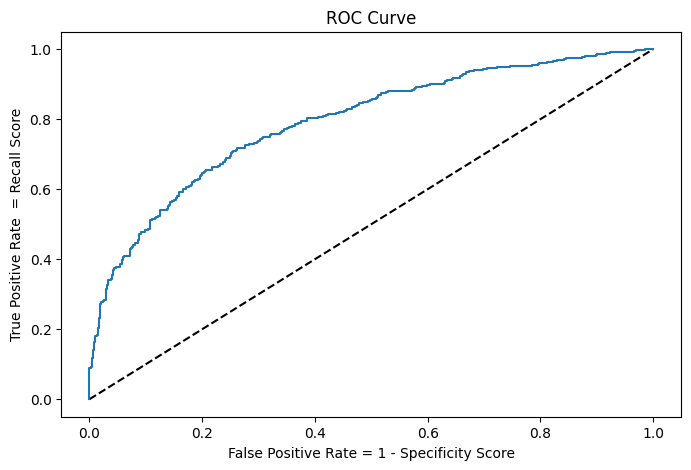

ROC AUC Value = 0.7922349587764734


In [31]:
from sklearn.metrics import confusion_matrix as cm
pred_test  = model.predict(X_test_scaled)
pred_train = model.predict(X_train_scaled)

confusion_matrix_train = cm(y_train,pred_train)
confusion_matrix_test = cm(y_test,pred_test)

TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

accuracy1 = model.score(X_test_scaled, y_test)
Error_Rate = 1- (accuracy_score(y_test, pred_test))

precision_s = precision_score(y_test, pred_test,average='micro')
recall_s    = recall_score(y_test, pred_test, average='micro')

print('Confusion Matrix Train Data', confusion_matrix_train, sep='\n')
print('--'*20)
print('Confusion Matrix Test Data', confusion_matrix_test, sep='\n')
print('--'*20)
print("(Total) True Negative       :", TN)
print("(Total) True Positive       :", TP)
print("(Total) Negative Positive   :", FP)
print("(Total) Negative Negative   :", FN)
print('--'*20)
print("Accuracy Score of Our Model     : ",  accuracy1)
print('--'*20)
print("Error Score of Our Model     : ",  Error_Rate)
print('--'*20)
print("precision_score()         : ",  precision_score(y_test, pred_test, average='micro'))
print('--'*20)
print("recall_score()            : ",  recall_score(y_test, pred_test, average='micro'))
print('--'*20)
print("Specificity Score   : ",  (TN)/(TN + FP))
print('--'*20)
print("F1_score     : ",  2*((precision_s*recall_s)/(precision_s + recall_s)))
print('--'*20)
print(classification_report(y_test,pred_test))
print('--'*20)

probs = model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thresholds  = roc_curve(y_test, probs)

plt.figure(figsize=(8,5))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

print(("ROC AUC Value ="), roc_auc_score(y_test.values, probs))

Confusion Matrix Train Data
[[1080  830]
 [ 553 2734]]
----------------------------------------
Confusion Matrix Test Data
[[251 223]
 [134 692]]
----------------------------------------
(Total) True Negative       : 251
(Total) True Positive       : 692
(Total) Negative Positive   : 223
(Total) Negative Negative   : 134
----------------------------------------
Accuracy Score of Our Model     :  0.7253846153846154
----------------------------------------
Error Score of Our Model     :  0.2746153846153846
----------------------------------------
precision_score()         :  0.7253846153846154
----------------------------------------
recall_score()            :  0.7253846153846154
----------------------------------------
Specificity Score   :  0.5295358649789029
----------------------------------------
F1_score     :  0.7253846153846153
----------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       474
   

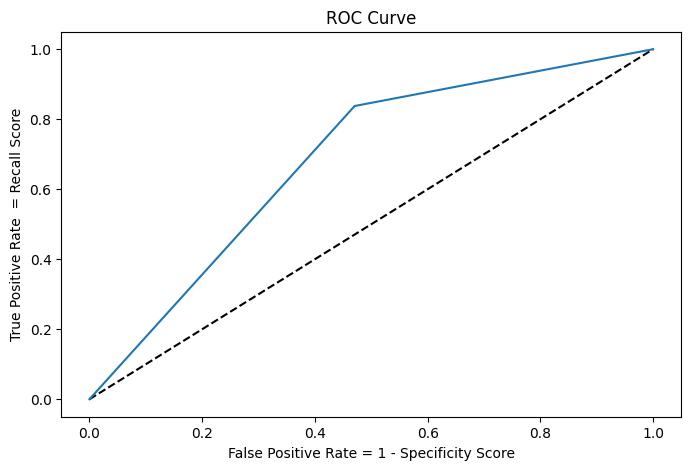

ROC AUC Value = 0.683654131036667


In [51]:
from sklearn.metrics import confusion_matrix as cm
pred_test2  = (hasil_AIC1.predict(X_test_AIC1_scaled_cons) > 0.5).astype(int)
pred_train2 = (hasil_AIC1.predict(X_train_AIC1_scaled_cons) > 0.5).astype(int)

y_pred_proba_train2 = 1 / (1 + np.exp(-pred_train2))
y_pred_proba_test2 = 1 / (1 + np.exp(-pred_test2))

confusion_matrix_train2 = cm(y_train_AIC1,pred_train2)
confusion_matrix_test2 = cm(y_test_AIC1,pred_test2)

TN2 = confusion_matrix_test2[0][0]
TP2 = confusion_matrix_test2[1][1]
FP2 = confusion_matrix_test2[0][1]
FN2 = confusion_matrix_test2[1][0]


accuracy2 = np.mean(y_pred_test_class2 == y_test_AIC1)

Error_Rate2 = 1- (accuracy_score(y_test_AIC1, y_pred_test_class2))

precision_s2 = precision_score(y_test_AIC1, y_pred_test_class2,average='micro')
recall_s2    = recall_score(y_test_AIC1, y_pred_test_class2, average='micro')

print('Confusion Matrix Train Data', confusion_matrix_train2, sep='\n')
print('--'*20)
print('Confusion Matrix Test Data', confusion_matrix_test2, sep='\n')
print('--'*20)
print("(Total) True Negative       :", TN2)
print("(Total) True Positive       :", TP2)
print("(Total) Negative Positive   :", FP2)
print("(Total) Negative Negative   :", FN2)
print('--'*20)
print("Accuracy Score of Our Model     : ", accuracy2)
print('--'*20)
print("Error Score of Our Model     : ",  Error_Rate2)
print('--'*20)
print("precision_score()         : ",  precision_score(y_test_AIC1, y_pred_test_class2, average='micro'))
print('--'*20)
print("recall_score()            : ",  recall_score(y_test_AIC1, y_pred_test_class2, average='micro'))
print('--'*20)
print("Specificity Score   : ",  (TN2)/(TN2 + FP2))
print('--'*20)
print("F1_score     : ",  2*((precision_s2*recall_s2)/(precision_s2 + recall_s2)))
print('--'*20)
print(classification_report(y_test_AIC1,y_pred_test_class2))
print('--'*20)




fpr2, tpr2, thresholds2  = roc_curve(y_test_AIC1, y_pred_proba_test2)

plt.figure(figsize=(8,5))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

print(("ROC AUC Value ="), roc_auc_score(y_test_AIC1.values, y_pred_proba_test2))

In [43]:
binary_pred_test2

array([1, 1, 1, ..., 1, 1, 1])

Confusion Matrix Train Data
[[1081  829]
 [ 558 2729]]
----------------------------------------
Confusion Matrix Test Data
[[251 223]
 [135 691]]
----------------------------------------
(Total) True Negative       : 251
(Total) True Positive       : 691
(Total) Negative Positive   : 223
(Total) Negative Negative   : 135
----------------------------------------
Accuracy Score of Our Model     :  0.7246153846153847
----------------------------------------
Error Score of Our Model     :  0.27538461538461534
----------------------------------------
precision_score()         :  0.7246153846153847
----------------------------------------
recall_score()            :  0.7246153846153847
----------------------------------------
Specificity Score   :  0.5295358649789029
----------------------------------------
F1_score     :  0.7246153846153847
----------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       474
  

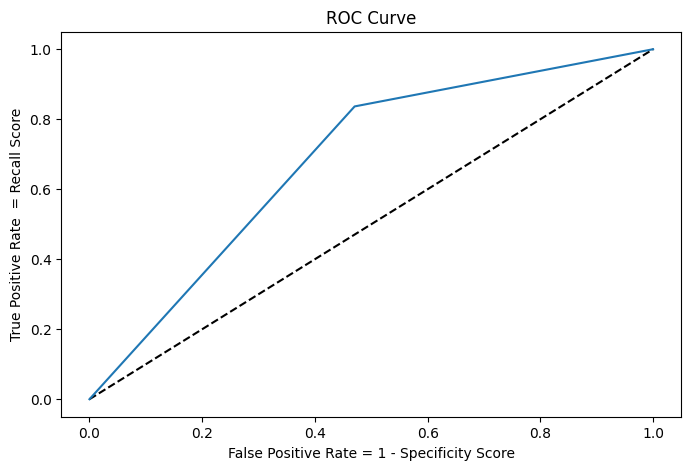

ROC AUC Value = 0.6830488041601537


In [52]:
from sklearn.metrics import confusion_matrix as cm
pred_test3  = (hasil.predict(X_test_wald) > 0.5).astype(int)
pred_train3 = (hasil.predict(X_train_wald) > 0.5).astype(int)

y_pred_proba_train3 = 1 / (1 + np.exp(-pred_train3))
y_pred_proba_test3 = 1 / (1 + np.exp(-pred_test3))

confusion_matrix_train3 = cm(y_train,pred_train3)
confusion_matrix_test3 = cm(y_test,pred_test3)

TN3 = confusion_matrix_test3[0][0]
TP3 = confusion_matrix_test3[1][1]
FP3 = confusion_matrix_test3[0][1]
FN3 = confusion_matrix_test3[1][0]

y_pred_test_class = (pred_test3 > 0.5).astype(int)
accuracy3 = np.mean(y_pred_test_class == y_test)

Error_Rate3 = 1- (accuracy_score(y_test, y_pred_test_class))

precision_s3 = precision_score(y_test, y_pred_test_class,average='micro')
recall_s3    = recall_score(y_test, y_pred_test_class, average='micro')

print('Confusion Matrix Train Data', confusion_matrix_train3, sep='\n')
print('--'*20)
print('Confusion Matrix Test Data', confusion_matrix_test3, sep='\n')
print('--'*20)
print("(Total) True Negative       :", TN3)
print("(Total) True Positive       :", TP3)
print("(Total) Negative Positive   :", FP3)
print("(Total) Negative Negative   :", FN3)
print('--'*20)
print("Accuracy Score of Our Model     : ",  accuracy3)
print('--'*20)
print("Error Score of Our Model     : ",  Error_Rate3)
print('--'*20)
print("precision_score()         : ",  precision_score(y_test, y_pred_test_class, average='micro'))
print('--'*20)
print("recall_score()            : ",  recall_score(y_test, y_pred_test_class, average='micro'))
print('--'*20)
print("Specificity Score   : ",  (TN3)/(TN3 + FP3))
print('--'*20)
print("F1_score     : ",  2*((precision_s3*recall_s3)/(precision_s3 + recall_s3)))
print('--'*20)
print(classification_report(y_test,y_pred_test_class))
print('--'*20)



fpr3, tpr3, thresholds3  = roc_curve(y_test, y_pred_proba_test3)

plt.figure(figsize=(8,5))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr3, tpr3)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

print(("ROC AUC Value ="), roc_auc_score(y_test.values, y_pred_proba_test3))

In [53]:
from sklearn.model_selection import cross_val_score
# Inisialisasi model Regresi Logistik
model = LogisticRegression(max_iter=1000)  # Sesuaikan nilai max_iter sesuai kebutuhan

# Lakukan cross-validation dengan 5 lipatan (folds) pada data latih yang telah diubah skala
cv_scores = cross_val_score(model, X_train_AIC1_scaled, y_train_AIC1, cv=5, scoring='accuracy')

# Buat DataFrame dari skor cross-validation
cv_results = pd.DataFrame({
    'Fold': range(1, len(cv_scores) + 1),
    'Accuracy': cv_scores
})

# Cetak DataFrame hasil cross-validation
print("Cross-Validation Results:")
print(cv_results)

# Cetak rata-rata akurasi
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Results:
   Fold  Accuracy
0     1  0.729808
1     2  0.746154
2     3  0.742060
3     4  0.720885
4     5  0.724735
Mean Accuracy: 0.7327284000888428


In [55]:
from sklearn.model_selection import GridSearchCV

# Definisikan grid parameter yang akan diuji
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
}

# Inisialisasi objek GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Lakukan grid search pada data latih yang telah diubah skala
grid_search.fit(X_train_AIC1_scaled, y_train_AIC1)

# Cetak parameter terbaik yang ditemukan
print("Best Parameters:", grid_search.best_params_)

# Cetak akurasi terbaik yang ditemukan
print("Best Accuracy:", grid_search.best_score_)

# Evaluasi model terbaik pada data uji
best_model = grid_search.best_estimator_
accuracy_test = best_model.score(X_test_AIC1_scaled, y_test_AIC1)
print("Accuracy on Test Data:", accuracy_test)

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Accuracy: 0.7327284000888428
Accuracy on Test Data: 0.7253846153846154


In [57]:
# Inisialisasi model dengan parameter terbaik
best_model = LogisticRegression(C=1, penalty='l2')

# Latih model pada data latih yang telah diubah skala
best_model.fit(X_train_AIC1_scaled, y_train_AIC1)

# Evaluasi model pada data uji
accuracy_test = best_model.score(X_test_AIC1_scaled, y_test_AIC1)

# Tampilkan hasil
print("Model yang Dilatih dengan Parameter Terbaik:")
print("Accuracy on Test Data:", accuracy_test)

Model yang Dilatih dengan Parameter Terbaik:
Accuracy on Test Data: 0.7253846153846154


Confusion Matrix Train Data
[[1080  830]
 [ 553 2734]]
----------------------------------------
Confusion Matrix Test Data
[[251 223]
 [134 692]]
----------------------------------------
(Total) True Negative       : 251
(Total) True Positive       : 692
(Total) Negative Positive   : 223
(Total) Negative Negative   : 134
----------------------------------------
Accuracy Score of Our Model     :  0.7253846153846154
----------------------------------------
Error Score of Our Model     :  0.2746153846153846
----------------------------------------
precision_score()         :  0.7253846153846154
----------------------------------------
recall_score()            :  0.7253846153846154
----------------------------------------
Specificity Score   :  0.5295358649789029
----------------------------------------
F1_score     :  0.7253846153846153
----------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       474
   

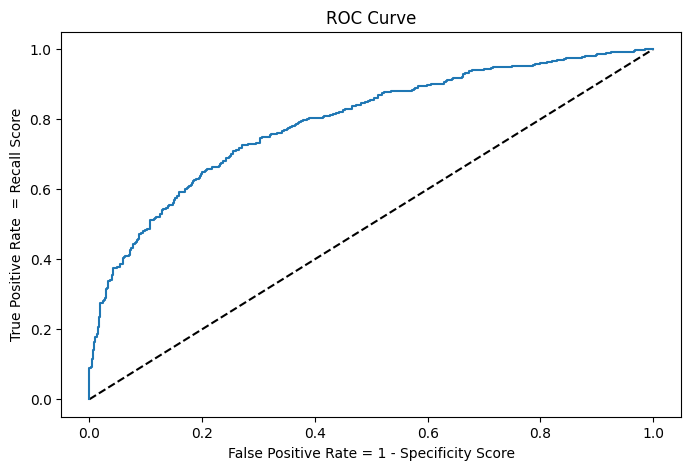

ROC AUC Value = 0.7921123609280657


In [58]:
from sklearn.metrics import confusion_matrix as cm
pred_test  = best_model.predict(X_test_AIC1_scaled)
pred_train = best_model.predict(X_train_AIC1_scaled)

confusion_matrix_train = cm(y_train_AIC1,pred_train)
confusion_matrix_test = cm(y_test_AIC1,pred_test)

TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

accuracy1 = best_model.score(X_test_AIC1_scaled, y_test_AIC1)
Error_Rate = 1- (accuracy_score(y_test_AIC1, pred_test))

precision_s = precision_score(y_test_AIC1, pred_test,average='micro')
recall_s    = recall_score(y_test_AIC1, pred_test, average='micro')

print('Confusion Matrix Train Data', confusion_matrix_train, sep='\n')
print('--'*20)
print('Confusion Matrix Test Data', confusion_matrix_test, sep='\n')
print('--'*20)
print("(Total) True Negative       :", TN)
print("(Total) True Positive       :", TP)
print("(Total) Negative Positive   :", FP)
print("(Total) Negative Negative   :", FN)
print('--'*20)
print("Accuracy Score of Our Model     : ",  accuracy1)
print('--'*20)
print("Error Score of Our Model     : ",  Error_Rate)
print('--'*20)
print("precision_score()         : ",  precision_score(y_test_AIC1, pred_test, average='micro'))
print('--'*20)
print("recall_score()            : ",  recall_score(y_test_AIC1, pred_test, average='micro'))
print('--'*20)
print("Specificity Score   : ",  (TN)/(TN + FP))
print('--'*20)
print("F1_score     : ",  2*((precision_s*recall_s)/(precision_s + recall_s)))
print('--'*20)
print(classification_report(y_test_AIC1,pred_test))
print('--'*20)

probs = best_model.predict_proba(X_test_AIC1_scaled)[:,1]

fpr, tpr, thresholds  = roc_curve(y_test_AIC1, probs)

plt.figure(figsize=(8,5))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

print(("ROC AUC Value ="), roc_auc_score(y_test_AIC1.values, probs))